In [5]:
import numpy as np 
import pandas as pd 
import random as rn
import re
import nltk
import os

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from nltk.corpus import stopwords
from wordcloud import WordCloud

import umap # dimensionality reduction
import hdbscan # clustering
from functools import partial

# To perform the Bayesian Optimization for searching the optimum hyperparameters, 
# we use hyperopt package:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

import collections
import spacy
from spacy import displacy

spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

import utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
rn.seed(a=42)

p = 1  # to randomly select 0.4% of the rows

df = pd.read_csv('./emails.csv', skiprows=lambda i: i>0 and rn.random() > p)
df['Content'] = df['Content'].apply(lambda x: re.sub(r'http\S+', '', str(x)))

# size of dataframe
print(df.shape)
# display the head of data
display(df.head())

(1000, 1)


,Content
0,"Hello Innovator, What if we told you that you could work with your dream company straight out of college? Yes! You heard it right! Participate in the Accenture Innovation Challenge to win big and you may also get an opportunity to fast-track your recruitment process journey with Accenture. Application Link: Roles Offered: Associate Software Engineer System and Application Services Associate R..."
1,"( ) Dear Innovator * * Congratulations!!!! We are delighted to inform you that your Cohort 6 Idea is successfully reserved a place in the Prototyping Stage. ( Click here ( ) to see the result) * * This achievement fills us with great satisfaction, and we wholeheartedly celebrate your progress. We firmly believe that your innovative idea has the potential to bring about meaningful change in s..."
2,"Hello aayushsenapati! Thanks for joining Docker. To finish registration, please click the button below to verify your account. Once verified, you can download Docker Desktop, create repositories and invite others to collaborate with you! If you have any questions or concerns, please contact us at hub-support@docker.com. Thank you! The Docker Team"
3,nan
4,"This week's theme: Words with AI usage examples secundan (se-KUHN-duhn) adjective Occurring every other day. [From Latin secundus (second). Earliest documented use: c. 1400.] A water conservation ad, Brisbane, Australia Photo: Tamara ""Forsooth! Sir Henry hath adopted a curious habit, taking his long walks secundan, as if the morrow's sun offends and the next shines but to please him."" Willia..."


In [17]:
df['Content'] = df['Content'].astype(str)

df.Content = df.Content.apply(lambda s : s.strip())

df_2 = df[df['Content'].notnull()]


df_2.head()

,Content
0,"Hello Innovator, What if we told you that you could work with your dream company straight out of college? Yes! You heard it right! Participate in the Accenture Innovation Challenge to win big and you may also get an opportunity to fast-track your recruitment process journey with Accenture. Application Link: Roles Offered: Associate Software Engineer System and Application Services Associate R..."
1,"( ) Dear Innovator * * Congratulations!!!! We are delighted to inform you that your Cohort 6 Idea is successfully reserved a place in the Prototyping Stage. ( Click here ( ) to see the result) * * This achievement fills us with great satisfaction, and we wholeheartedly celebrate your progress. We firmly believe that your innovative idea has the potential to bring about meaningful change in s..."
2,"Hello aayushsenapati! Thanks for joining Docker. To finish registration, please click the button below to verify your account. Once verified, you can download Docker Desktop, create repositories and invite others to collaborate with you! If you have any questions or concerns, please contact us at hub-support@docker.com. Thank you! The Docker Team"
3,nan
4,"This week's theme: Words with AI usage examples secundan (se-KUHN-duhn) adjective Occurring every other day. [From Latin secundus (second). Earliest documented use: c. 1400.] A water conservation ad, Brisbane, Australia Photo: Tamara ""Forsooth! Sir Henry hath adopted a curious habit, taking his long walks secundan, as if the morrow's sun offends and the next shines but to please him."" Willia..."


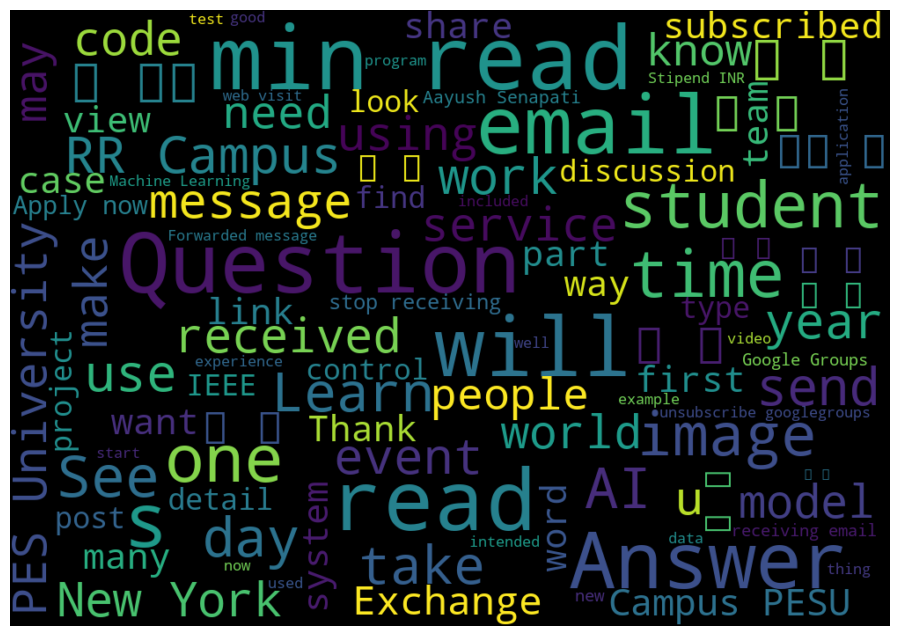

In [18]:
txt = ' '.join(rev for rev in df_2.Content )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100, 
    width=1000, 
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()

In [20]:
df_2 = df_2[df_2.Content != 'Early Access Review']

df_2 = df_2[~df_2.Content.isin(['nan'])]



df_2.drop_duplicates(['Content'], inplace = True )

print(df_2.shape)

(703, 1)


In [21]:


df_2.head()



,Content
0,"Hello Innovator, What if we told you that you could work with your dream company straight out of college? Yes! You heard it right! Participate in the Accenture Innovation Challenge to win big and you may also get an opportunity to fast-track your recruitment process journey with Accenture. Application Link: Roles Offered: Associate Software Engineer System and Application Services Associate R..."
1,"( ) Dear Innovator * * Congratulations!!!! We are delighted to inform you that your Cohort 6 Idea is successfully reserved a place in the Prototyping Stage. ( Click here ( ) to see the result) * * This achievement fills us with great satisfaction, and we wholeheartedly celebrate your progress. We firmly believe that your innovative idea has the potential to bring about meaningful change in s..."
2,"Hello aayushsenapati! Thanks for joining Docker. To finish registration, please click the button below to verify your account. Once verified, you can download Docker Desktop, create repositories and invite others to collaborate with you! If you have any questions or concerns, please contact us at hub-support@docker.com. Thank you! The Docker Team"
4,"This week's theme: Words with AI usage examples secundan (se-KUHN-duhn) adjective Occurring every other day. [From Latin secundus (second). Earliest documented use: c. 1400.] A water conservation ad, Brisbane, Australia Photo: Tamara ""Forsooth! Sir Henry hath adopted a curious habit, taking his long walks secundan, as if the morrow's sun offends and the next shines but to please him."" Willia..."
5,"Hey Aayush, August is over! Visit Splitwise to see your current debts and IOUs and to settle up with your friends: Any comments, thoughts, or suggestions? Hit reply and let us know. Have a great day! -The Splitwise Team Splitwise, Inc. 150 Union St, Suite 606 Providence, RI 02903 USA unsubscribe"


In [22]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)